In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#setting plot size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,7

In [2]:
train = pd.read_csv("data/training.csv")
test = pd.read_csv("data/testing.csv")

In [3]:
train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,153.723801,160.309128,152.179596,160.060059,160.060059,7248066
1,2009-01-05,159.900650,165.001541,156.911850,163.412491,163.412491,9814650
2,2009-01-06,165.868286,169.763687,162.585587,166.406265,166.406265,12898566
3,2009-01-07,163.546982,164.837143,158.779861,160.403763,160.403763,9022693
4,2009-01-08,158.545731,161.987823,158.077484,161.987823,161.987823,7228393
...,...,...,...,...,...,...,...
2260,2017-12-22,1061.109985,1064.199951,1059.439941,1060.119995,1060.119995,755100
2261,2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
2262,2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
2263,2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100


In [4]:
test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1048.339966,1066.939941,1045.229980,1065.000000,1065.000000,1237600
1,2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1082.479980,1430200
2,2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1086.400024,1004600
3,2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1102.229980,1279100
4,2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1106.939941,1047600
...,...,...,...,...,...,...,...
497,2019-12-23,1355.869995,1359.800049,1346.510010,1348.839966,1348.839966,883100
498,2019-12-24,1348.500000,1350.260010,1342.780029,1343.560059,1343.560059,347500
499,2019-12-26,1346.170044,1361.327026,1344.469971,1360.400024,1360.400024,667500
500,2019-12-27,1362.989990,1364.530029,1349.310059,1351.890015,1351.890015,1038400


In [5]:
df_clc = {}
df_clc[0] = train
df_clc[1] = test
df_idx = ["training", "testing"]

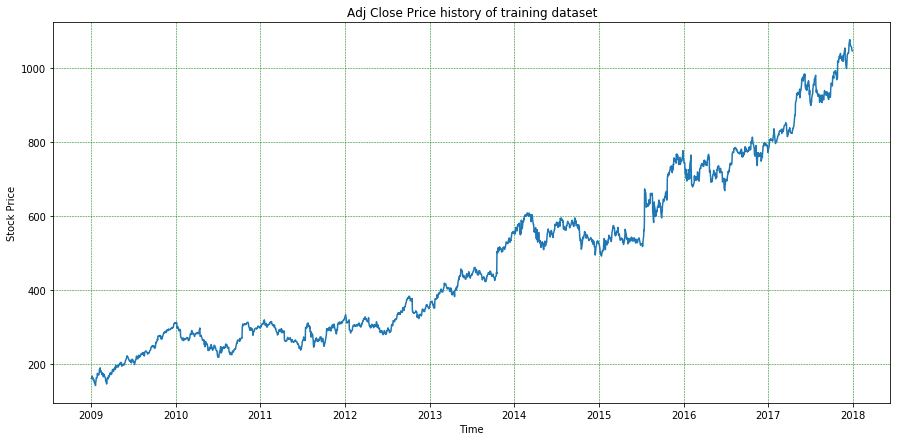

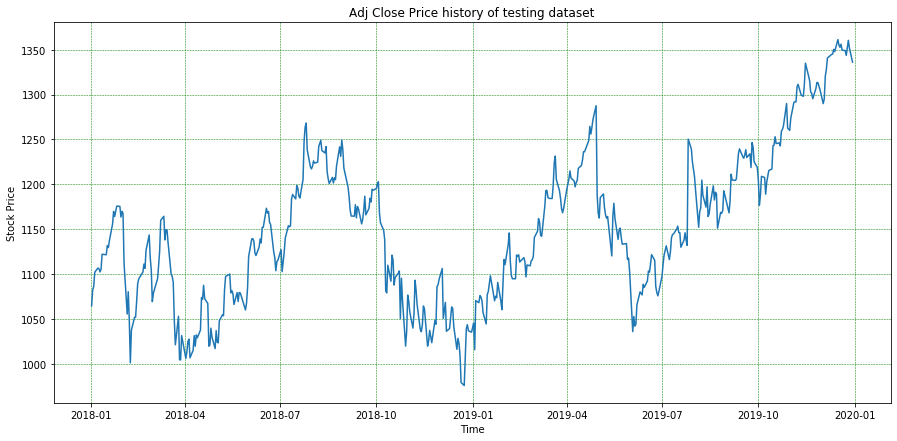

In [6]:
for i in range(0,2):
     df = df_clc[i]

     #setting index as date
     df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
     df.index = df['Date']
     
     #Ploting Adj Close Price history
     plt.plot(df['Adj Close'])
     plt.title("Adj Close Price history of " + df_idx[i] + " dataset")
     plt.xlabel("Time")
     plt.ylabel("Stock Price")
     plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
     plt.show()
     print("\n")

In [7]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import math
import random
from collections import deque

In [8]:
class Agent():
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # n previous days
        self.action_size = 3 # hold, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval 
        self.gamma = 0.95
        self.epsilon = 1.0 
        self.epsilon_min = 0.01
        self.epsilon_decay = (0.995)
        self.model = load_model(model_name) if is_eval else self._model()
        
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size , activation="linear"))
        opt = Adam(learning_rate=0.001)
        model.compile(loss="mse")
        return model

    def act(self, state):
        #exploration
        if not self.is_eval and random.random()<= self.epsilon:
            return random.randrange(self.action_size)
        #exploitation
        else :
            options = self.model.predict(state)
            return np.argmax(options[0])
    
    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])#Bellman Eq
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [9]:
def formatPrice(n):
    return("-$ " if n<0 else "$ ")+"{0:.2f}".format(abs(n))
    
def getStockDataVec(key):
    vec = []
    lines = open("./data/"+ key+".csv","r").read().splitlines()
    for line in lines[1:]:
        vec.append(float(line.split(",")[4]))
    return vec 

def getState(data, t, n):
    d = t-n+1
    window = data[d:t+1] if d>=0 else -d*[data[0]] + data[0:t+1] #pad with t_0
    return np.array([window])
        

In [10]:
# model parameters
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = epsilon_max - epsilon_min  # Rate at which to reduce chance of random action being taken
batch_size = 5  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

In [11]:
# trading parameters
Max_Transactions = 100 #After a sell
Total_Money =  100000
bought_price = 0
Current_Stocks_Bought = 0
Current_Transaction_Count = 0 

In [12]:
def calc_asset(money,stocks_bought, data, time):
    return (money + stocks_bought*data[time])

def max_asset(data, time):
    opt_0 = calc_asset(Total_Money, Current_Stocks_Bought ,data, time+1) # hold
    
    opt_1 = 0 # buy
    if Current_Transaction_Count < Max_Transactions:
        x = Total_Money/(Max_Transactions - Current_Transaction_Count)
        y = x/data[time]
        opt_1 = calc_asset(Total_Money - x, Current_Stocks_Bought + y, data , time+1)

    opt_2 = calc_asset(Total_Money + Current_Stocks_Bought*data[time], 0, data, time +1) #sell

    return max(opt_0, opt_1, opt_2)


## Training

In [13]:
import sys
max_episodes = 5
window_size = 6 # window to give state
agent = Agent(window_size)
stock_name = "training"
data = getStockDataVec(stock_name)
t_max = len(data) 
print(t_max)

original_stdout = sys.stdout
OutputFile = open("train_out.txt", "w")
sys.stdout = OutputFile

for episode in range(max_episodes):
    # trading parameters
    Max_Transactions = 100 #After a sell
    Total_Money =  100000
    bought_price = 0
    Current_Stocks_Bought = 0
    Current_Transaction_Count = 0 
    print("Episode " + str(episode+1) + "/" + str(max_episodes))
    state = getState(data, 0, window_size)
    total_profit = 0

    for time in range(t_max-1):
        action = agent.act(state)

        next_state = getState(data, time+1, window_size)
        reward = 0 

        # asset = total money + stocks value
        max_profile = max_asset(data, time)

        if action == 0: #hold
            reward = calc_asset(Total_Money, Current_Stocks_Bought, data, time+1) - max_profile
            print("time: "+ str(time) +" Hold: " + " reward:" + str(reward) + " Asset:" + str(formatPrice(calc_asset(Total_Money, Current_Stocks_Bought, data, time))))

        elif action == 1 and Current_Transaction_Count < Max_Transactions:#buy
            x = Total_Money/(Max_Transactions - Current_Transaction_Count)
            Total_Money -= x
            bought_price += x
            Current_Stocks_Bought += x/data[time]
            Current_Transaction_Count += 1

            reward = calc_asset(Total_Money , Current_Stocks_Bought, data, time+1) - max_profile
            print("time: "+ str(time) +" Buy: " + " reward:" + str(reward) + " Asset:" + str(formatPrice(calc_asset(Total_Money, Current_Stocks_Bought, data, time))))


        elif action == 2: #sell
            sell_price = data[time] * Current_Stocks_Bought
            reward = sell_price - bought_price
            total_profit += reward

            Total_Money += sell_price
            bought_price = 0
            Current_Stocks_Bought = 0
            Current_Transaction_Count = 0
            
            reward = calc_asset(Total_Money, Current_Stocks_Bought, data, time+1) - max_profile
            print("time: "+ str(time) +" Sell: " + " reward:" + str(reward) + " Asset:" + str(formatPrice(calc_asset(Total_Money, Current_Stocks_Bought, data, time))))



        done = True if time == t_max-2 else False
        agent.memory.append((state, action, reward, next_state, done))

        state = next_state
        if done:
            print("################################")
            print("Total Profit: " + formatPrice(total_profit))
            print("################################")
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)
    if episode == max_episodes-1:
        # indexing starts from 0
        agent.model.save("Model_" + str(max_episodes))

sys.stdout = original_stdout

2265
INFO:tensorflow:Assets written to: Model_5\assets


In [14]:
# trading parameters
Max_Transactions = 100 #After a sell
Total_Money =  100000
bought_price = 0
Current_Stocks_Bought = 0
Current_Transaction_Count = 0 

## Testing

In [15]:
model_name = "Model_5"
stock_name = "testing"
model = load_model(model_name)
window_size = model.layers[0].input.shape.as_list()[1]
agent = Agent(window_size, True, model_name)
data = getStockDataVec(stock_name)
print(data)
t_max = len(data) 
print(t_max)

original_stdout = sys.stdout
OutputFile = open("test_out.txt", "w")
sys.stdout = OutputFile

state = getState(data, 0, window_size)
total_profit = 0

for time in range(t_max-1):
    action = agent.act(state)

    next_state = getState(data, time+1, window_size)
    #Hold: action == 0
    reward = 0

    if action == 1 and Current_Transaction_Count < Max_Transactions: # buy
        x = Total_Money/(Max_Transactions - Current_Transaction_Count)
        Total_Money -= x
        bought_price += x
        Current_Stocks_Bought += x/data[time]
        Current_Transaction_Count += 1
        print("time: "+ str(time) +" Buy: " + formatPrice(data[time]))

    elif action == 2: #sell
        sell_price = data[time] * Current_Stocks_Bought
        reward = sell_price - bought_price
        total_profit += reward

        Total_Money += sell_price
        bought_price = 0
        Current_Stocks_Bought = 0
        Current_Transaction_Count = 0
        print("time: "+str(time) +" Sell: " + formatPrice(data[time]) + " | Profit: " + formatPrice(sell_price - bought_price)
        + " | Total Profit: " + formatPrice(total_profit))


    done = True if time == t_max-2 else False
    agent.memory.append((state, action, reward, next_state, done))

    state = next_state
    if done:
        print("################################")
        print("Total Profit: " + formatPrice(total_profit))
        print("################################")

[1065.0, 1082.47998, 1086.400024, 1102.22998, 1106.939941, 1106.26001, 1102.609985, 1105.52002, 1122.26001, 1121.76001, 1131.97998, 1129.790039, 1137.51001, 1155.810059, 1169.969971, 1164.23999, 1170.369995, 1175.839966, 1175.579956, 1163.689941, 1169.939941, 1167.699951, 1111.900024, 1055.800049, 1080.599976, 1048.579956, 1001.52002, 1037.780029, 1051.939941, 1052.099976, 1069.699951, 1089.52002, 1094.800049, 1102.459961, 1111.339966, 1106.630005, 1126.790039, 1143.75, 1118.290039, 1104.72998, 1069.52002, 1078.920044, 1090.930054, 1095.060059, 1109.640015, 1126.0, 1160.040039, 1164.5, 1138.170044, 1149.48999, 1149.579956, 1135.72998, 1099.819946, 1097.709961, 1090.880005, 1049.079956, 1021.570007, 1053.209961, 1005.099976, 1004.559998, 1031.790039, 1006.469971, 1013.409973, 1025.140015, 1027.810059, 1007.039978, 1015.450012, 1031.640015, 1019.969971, 1032.51001, 1029.27002, 1037.97998, 1074.160034, 1072.079956, 1087.699951, 1072.959961, 1067.449951, 1019.97998, 1021.179993, 1040.04003